In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../')

from refellips.structureSE import RI
from refellips.dataSE import DataSE
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE

# Test 1

Check bare interface ellipsometry calcualtion against wvase

Test passed


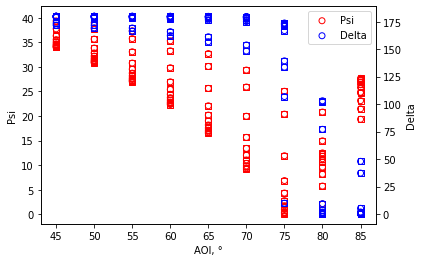

In [3]:
dname = 'TestData_bareSI.txt'
data = DataSE(data=dname)

si     = RI('../materials/silicon.csv')
void   = RI('../materials/void.csv')
struc  = void() | si()
model  = ReflectModelSE(struc, wavelength=658)

fig, ax = plt.subplots()
axt = ax.twinx()
test_arr = []

for dat in data:
    model.wav = dat._current_wav
    aois = dat.aoi
    psi, delta = model(aois)
    ax.scatter(aois, psi, facecolor='none', color='r', marker='s')
    p = ax.scatter(dat.aoi, dat.psi, facecolor='none', color='r')
    test_arr.append(np.abs(np.array(psi-dat.psi)/dat.psi)<0.005)
    test_arr.append(np.abs(np.array(delta-dat.delta)/dat.delta)<0.005)

    axt.scatter(aois, delta, facecolor='none', color='b', marker='s')
    d = axt.scatter(dat.aoi, dat.delta, facecolor='none', color='b')

    ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
    ax.set(ylabel='Psi', xlabel='AOI, °')
    axt.set(ylabel='Delta')
    
test_arr = np.array(test_arr)

if np.prod(test_arr, dtype=np.bool):
    print ('Test passed')
else:
    print ('test failed')

# Test 2
Check the cauchy model behaves as expected

test passed


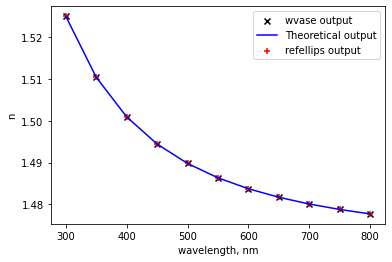

In [4]:
fig, ax = plt.subplots()

A = 1.47
B = 0.00495
C = 0

si     = RI('../materials/silicon.csv')
void   = RI('../materials/void.csv')
cauchy = RI(A=A, B=B, C=C)
struc  = void() | cauchy(1000) | si()
model  = ReflectModelSE(struc, wavelength=658)


wvase_output = np.loadtxt('Cauchynk_fromWVASE.txt')
wavs = wvase_output[:,0]
refin = A + B/((wavs/1000)**2) + C/((wavs/1000)**4)

ax.scatter(wvase_output[:,0], wvase_output[:,1], marker='x', color='k', label='wvase output')
ax.plot(wavs, refin, color='b', label='Theoretical output')


refellips_RI = [] 
for wav in wavs:
    model.wav = wav
    refellips_RI.append(cauchy.real.value)

ax.scatter(wavs, refellips_RI, color='r', marker='+', label='refellips output')

ax.set(ylabel='n', xlabel='wavelength, nm')
ax.legend()

passarr_wvase  = np.abs(refellips_RI - wvase_output[:,1])/wvase_output[:,1] < 0.01
passarr_theory = np.abs(refellips_RI - refin)/refin < 0.01

if np.all([passarr_wvase, passarr_theory]):
    print('test passed')
else:
    print('test failed')

# Test 3
Three layer stack (cauchy & from file) compared to wvase

Also tests behaviour of Delta around 180°

Test passed


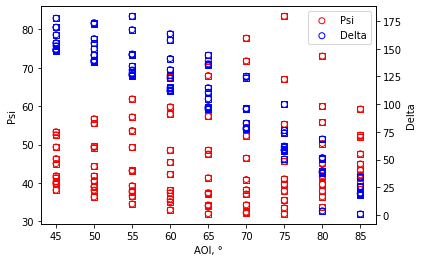

In [5]:
dname = 'TestData_cauchy.txt'
data = DataSE(data=dname)

si     = RI('../materials/silicon.csv')
void   = RI('../materials/void.csv')
cauchy = RI(A=1.47, B=0.00495, C=0)
struc  = void() | cauchy(1000) | si()
model  = ReflectModelSE(struc, wavelength=658)
model._flip_delta = True # This will be automatically set when analysing data

fig, ax = plt.subplots()
axt = ax.twinx()
test_arr = []

for dat in data:
    model.wav = dat._current_wav
    aois = dat.aoi
    psi, delta = model(aois)
    ax.scatter(aois, psi, facecolor='none', color='r', marker='s')
    p = ax.scatter(dat.aoi, dat.psi, facecolor='none', color='r')
    test_arr.append(np.abs(np.array(psi-dat.psi)/dat.psi)<0.005)
    test_arr.append(np.abs(np.array(delta-dat.delta)/dat.delta)<0.005)

    axt.scatter(aois, delta, facecolor='none', color='b', marker='s')
    d = axt.scatter(dat.aoi, dat.delta, facecolor='none', color='b')

    ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
    ax.set(ylabel='Psi', xlabel='AOI, °')
    axt.set(ylabel='Delta')
    
test_arr = np.array(test_arr)

if np.prod(test_arr, dtype=np.bool):
    print ('Test passed')
else:
    print ('test failed')